## STOCK MARKET - Window method IndRNN

### Problem Description
The problem we are going to look at in this post is the stock market prices prediction problem.

This is a problem where, given a day, month, and a year, the task is to predict the price of next days stocks . The data ranges from 1996 to 2010,  with 4836 observations.

** Name of the Dataset **  “TATAMOTORS.BO.xlsx'“

In [200]:
from __future__ import print_function
import os
import numpy
import pandas
import math

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from ind_rnn import IndRNNCell, RNN

In [201]:
dataset = pandas.read_excel('ETHUSD=X.xlsx', usecols=[0,4], skipfooter=3)
dataset.fillna(method='ffill', inplace=True)

dataset.head()

,Date,Close
0,2015-08-07,2.772120
1,2015-08-10,0.708448
2,2015-08-11,1.067860
3,2015-08-12,1.217440
4,2015-08-13,1.827670


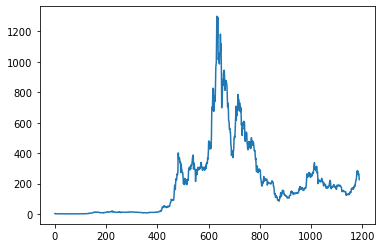

In [202]:
plt.plot(dataset['Close'])
plt.show()

#### Normally, it is a good idea to investigate various data preparation techniques to rescale the data and to make it stationary.

Before we do anything, it is a good idea to fix the random number seed to ensure our results are reproducible

In [203]:
# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset sales-of-soaps.csv
dataframe = pandas.read_excel('ETHUSD=X.xlsx', usecols=[4])
#dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python')
dataframe.fillna(method='ffill', inplace=True)

dataframe.head()
#print(type(dataframe.dtypes))

,Close
0,2.772120
1,0.708448
2,1.067860
3,1.217440
4,1.827670


- ** extract the NumPy array from the dataframe** <br>
- Then **convert the integer values to floating point values**, which are more suitable for modeling with a neural network.

In [204]:
dataset = dataframe.values      ##   convert the data-frame to its Numpy-array
dataset = dataset.astype('float32')

In [205]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(type(dataframe.dtypes))

<class 'pandas.core.series.Series'>


Doing a Train-Test Split<br>
Train: 67%<br>
Test:  33%

In [206]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

798 394


In [207]:
forward_days=10
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=40):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-forward_days+1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)


Let’s use this function to prepare the train and test datasets for modeling.

In [208]:
# reshape into X=t and Y=t+1
look_back = 40

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [209]:
# reshape input to be [samples, time steps, features]

trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX.shape

(749, 40, 1)

In [210]:
batch_size = 40
num_classes = 10
epochs = 10     # 200  
hidden_units = 64  # 128

learning_rate = 1e-3

In [128]:
#from keras.models import load_model

# cells = [IndRNNCell(hidden_units), IndRNNCell(hidden_units)]
cells = [IndRNNCell(4), IndRNNCell(4)]

from ind_rnn import IndRNNCell, RNN
from ind_rnn import IndRNN
#model = load_model('my_model.h5',  custom_objects={'IndRNNCell': IndRNNCell, 'IndRNN': IndRNN})

In [129]:

print('Evaluate IRNN...')
from ind_rnn import IndRNNCell, RNN
from ind_rnn import IndRNN

# create the IndRNN network
model = Sequential()
model.add(RNN(cells, input_shape=(look_back, 1), return_sequences=True))
model.add(IndRNN(32, recurrent_clip_min=-1, recurrent_clip_max=-1, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
model.add(RNN(cells, return_sequences=True))
model.add(IndRNN(32, recurrent_clip_min=-1, recurrent_clip_max=-1, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
model.add(RNN(cells, return_sequences=False))
model.add(Dense(1))

from keras import optimizers
#optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

#adam = optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='mean_squared_error', optimizer= 'adam', metrics=['accuracy'])


'''
Return sequences
Return sequences refer to return the hidden state a<t>. By default, the return_sequences is set to False in Keras RNN layers, and this means the RNN layer will only return the last hidden state output a<T>. The last hidden state output captures an abstract representation of the input sequence. In some case, it is all we need, such as a classification or regression model where the RNN is followed by the Dense layer(s) to generate logits for news topic classification or score for sentiment analysis, or in a generative model to produce the softmax probabilities for the next possible char.

In other cases, we need the full sequence as the output. Setting return_sequences to True is necessary.
'''

Evaluate IRNN...


C:\Users\1864012\Documents\THESIS CODES NEW\Conference Results\ind_rnn.py:143: UserWarning: IndRNNCell: Number of timesteps could not be determined. 
Defaulting to max clipping range of 1.0. 
If this model was trained using a specific timestep during training, inference may be wrong due to this default setting.
Please ensure that you use the same number of timesteps during training and evaluation
  warnings.warn("IndRNNCell: Number of timesteps could not be determined. \n"


'\nReturn sequences\nReturn sequences refer to return the hidden state a<t>. By default, the return_sequences is set to False in Keras RNN layers, and this means the RNN layer will only return the last hidden state output a<T>. The last hidden state output captures an abstract representation of the input sequence. In some case, it is all we need, such as a classification or regression model where the RNN is followed by the Dense layer(s) to generate logits for news topic classification or score for sentiment analysis, or in a generative model to produce the softmax probabilities for the next possible char.\n\nIn other cases, we need the full sequence as the output. Setting return_sequences to True is necessary.\n'

In [189]:
#model.summary()
print(model.layers)
print(model.inputs)
print(model.outputs)
#print(model.get_config())

[<keras.layers.recurrent.RNN object at 0x00000213E9327A88>, <ind_rnn.IndRNN object at 0x00000213E9327F48>, <keras.layers.recurrent.RNN object at 0x00000213E9316EC8>, <ind_rnn.IndRNN object at 0x00000213E940E608>, <keras.layers.recurrent.RNN object at 0x00000213E9316F88>, <keras.layers.core.Dense object at 0x00000213E93337C8>]
[<tf.Tensor 'rnn_13_input:0' shape=(None, 40, 1) dtype=float32>]
[<tf.Tensor 'dense_5/BiasAdd:0' shape=(None, 1) dtype=float32>]


In [211]:
adam = optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='mean_squared_error', optimizer= 'adam', metrics=['accuracy'])

In [212]:
%%time
# Fit the LSTM network
import keras
#mcc = keras.callbacks.callbacks.ModelCheckpoint("mcc", monitor='loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=10)

#es = keras.callbacks.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)


model.fit(trainX, trainY, epochs=100, batch_size=20, verbose=2)

Epoch 1/100
 - 3s - loss: 5.5787e-04 - accuracy: 0.0013
Epoch 2/100
 - 1s - loss: 4.9463e-04 - accuracy: 0.0013
Epoch 3/100
 - 2s - loss: 5.3757e-04 - accuracy: 0.0013
Epoch 4/100
 - 2s - loss: 4.7017e-04 - accuracy: 0.0013
Epoch 5/100
 - 2s - loss: 4.8407e-04 - accuracy: 0.0013
Epoch 6/100
 - 2s - loss: 4.6665e-04 - accuracy: 0.0013
Epoch 7/100
 - 2s - loss: 4.7898e-04 - accuracy: 0.0013
Epoch 8/100
 - 2s - loss: 4.8728e-04 - accuracy: 0.0013
Epoch 9/100
 - 2s - loss: 5.3758e-04 - accuracy: 0.0013
Epoch 10/100
 - 2s - loss: 5.2371e-04 - accuracy: 0.0013
Epoch 11/100
 - 2s - loss: 5.4651e-04 - accuracy: 0.0013
Epoch 12/100
 - 2s - loss: 4.6101e-04 - accuracy: 0.0013
Epoch 13/100
 - 2s - loss: 4.6998e-04 - accuracy: 0.0013
Epoch 14/100
 - 2s - loss: 4.5713e-04 - accuracy: 0.0013
Epoch 15/100
 - 2s - loss: 4.8575e-04 - accuracy: 0.0013
Epoch 16/100
 - 2s - loss: 4.7776e-04 - accuracy: 0.0013
Epoch 17/100
 - 2s - loss: 5.1146e-04 - accuracy: 0.0013
Epoch 18/100
 - 2s - loss: 4.6662e-04 - 

Once the model is fit, we can estimate the performance of the model on the train and test datasets.

In [213]:
scores = model.evaluate(trainX, trainY, verbose=0)
#model.save_weights('IndRNN_weights.h5')


In [214]:
from keras.models import load_model

print(scores)
print(model.metrics_names)

[0.00043916955664960244, 0.0013351135421544313]
['loss', 'accuracy']


In [215]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

***Note that we invert the predictions before calculating error scores 
to ensure that performance is reported in the same units as the original data (stock prices).***

In [216]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [217]:
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (testScore))

Train Score: 741.40 MSE
Test Score: 239.16 MSE


In [218]:
## LSTM   - Train Score: 23.70 RMSE Test Score: 58.87 RMSE (LSTM - 4)
## IndRNN - Train Score: 24.05 RMSE Test Score: 52.45 RMSE [Cell = 4,4]
## IndRNN - Train Score: 23.99 RMSE Test Score: 51.99 RMSE [Cell = 3,3]
## IndRnn - Train Score: 23.25 RMSE Test Score: 49.35 RMSE [Cell = 3,3] Look-back=6

In [219]:

"""
import random
from random import randrange
for i in range(0,len(testPredict)):
    random.seed(random.random())

    testPredict[i]=testPredict[i]+random.randint(-10,10)
    random.seed(a=None, version=2)
    random.seed(random.random())
"""

'\nimport random\nfrom random import randrange\nfor i in range(0,len(testPredict)):\n    random.seed(random.random())\n\n    testPredict[i]=testPredict[i]+random.randint(-10,10)\n    random.seed(a=None, version=2)\n    random.seed(random.random())\n'

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in black.

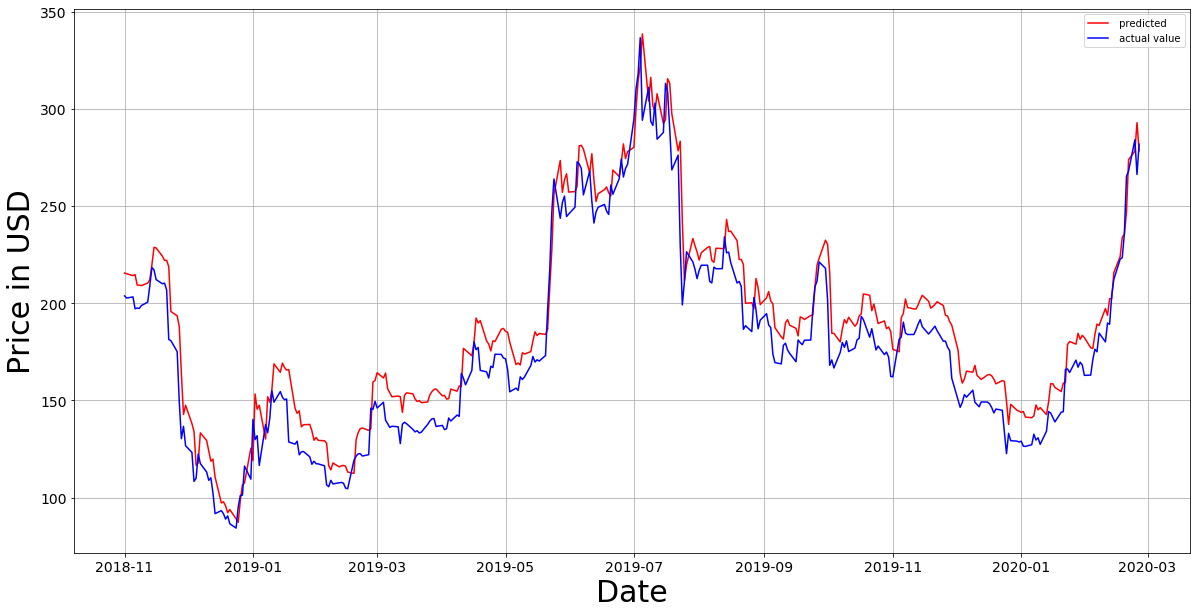

In [220]:
datedate = pandas.read_excel('ETHUSD=X.xlsx', usecols=[0], skipfooter=3)

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(datedate.tail(345),testPredict, label=' predicted', color='red')
plt.plot(datedate.tail(345),testY[0], label=' actual value', color='blue')
plt.xlabel('Date', fontsize=30)
plt.ylabel('Price in USD', fontsize=30)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()

plt.show()